# Data Cleaning

In [226]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics

In [227]:
df = pd.read_csv('data-pozo/kc_house_data.csv')

In [228]:
#drop rows with null values
df.dropna(subset = ['heat_source', 'sewer_system'], inplace = True)

In [229]:
#change date to datetime and split out sale year and month
df['date'] = pd.to_datetime(df['date'])
df['sale_month'] = df['date'].dt.month.astype(int)
df['sale_year'] = df['date'].dt.year.astype(int)

In [230]:
#drop rows containing addresses not in King County
        
zip_list = [98052,98115,98103,98092,98042,98023,98105,98003,98034,98118,98133,98058,98125,98031,98122,98033,98006,98032,98030,98004,98001,98059,98117,98056,98198,98168,98155,98027,98109,98002,98038,98144,98146,98074,98119,98007,98040,98029,98107,98011,98108,98072,98106,98178,98116,98112,98008,98053,98028,98126,98188,98102,98055,98075,98177,98022,98166,98199,98005,98121,98136,98045,98057,98019,98104,98077,98101,98065,98148,98070,98014,98354,98024,98051,98010,98047,98251,98134,98039,98195,98158,98068,98256,98288,98050,98132,98171,98184,98054,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98151,98154,98160,98164,98161,98165,98170,98174,98175,98181,98185,98190,98194,98191,98224,98471,98481]
zip_list = list(map(lambda x: str(x), zip_list))

df['in_target_area'] = df['address'].apply(lambda x: any(zip_code in x for zip_code in zip_list))
df = df.drop(df[df['in_target_area'] == False].index)

In [231]:
# Breakout city and zipcode from the address column

def residential_check(value):
    if len(value.split(',')) == 4:
        return True
    if len(value.split(',')) != 4:
        return False

df['residential'] = df['address'].apply(lambda x: residential_check(x))    
df = df.drop(df[df['residential'] == False].index)
df[['House_Num', 'City', 'State_ZIP', 'Country']] = df['address'].str.split(',', expand=True)    
df[['Empty', 'State', 'ZIP']] = df['State_ZIP'].str.split(' ', expand=True) 
df.drop(columns = ['Empty', 'in_target_area', 'residential'], inplace = True)
df["City"] = df["City"].apply(lambda x: x.strip())
df["ZIP"] = df["ZIP"].apply(lambda x: x.strip())
df["House_Num"] = df["House_Num"].apply(lambda x: x.strip())

In [232]:
# Drop all duplicated housing IDs and addresses. Drop homes missing bed/bath data
df['id'].duplicated().value_counts()
df.drop_duplicates(subset = 'id', keep = 'first', inplace = True)


df['address'].duplicated().value_counts() 
df.sort_values(by = ['date'], ascending = False, inplace = True)
df.drop_duplicates(subset = ['address'], keep = 'first', inplace = True)

df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]
df = df[df['bedrooms'] < 10]

df.reset_index(drop = True, inplace = True)
df.drop(columns=['id', 'date', 'address', 'lat', 'long', 'House_Num', 'State_ZIP', 'Country', 'State'], inplace = True)

In [233]:
#initial clean dataset, dropping useless columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28966 entries, 0 to 28965
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          28966 non-null  float64
 1   bedrooms       28966 non-null  int64  
 2   bathrooms      28966 non-null  float64
 3   sqft_living    28966 non-null  int64  
 4   sqft_lot       28966 non-null  int64  
 5   floors         28966 non-null  float64
 6   waterfront     28966 non-null  object 
 7   greenbelt      28966 non-null  object 
 8   nuisance       28966 non-null  object 
 9   view           28966 non-null  object 
 10  condition      28966 non-null  object 
 11  grade          28966 non-null  object 
 12  heat_source    28966 non-null  object 
 13  sewer_system   28966 non-null  object 
 14  sqft_above     28966 non-null  int64  
 15  sqft_basement  28966 non-null  int64  
 16  sqft_garage    28966 non-null  int64  
 17  sqft_patio     28966 non-null  int64  
 18  yr_bui

# EDA

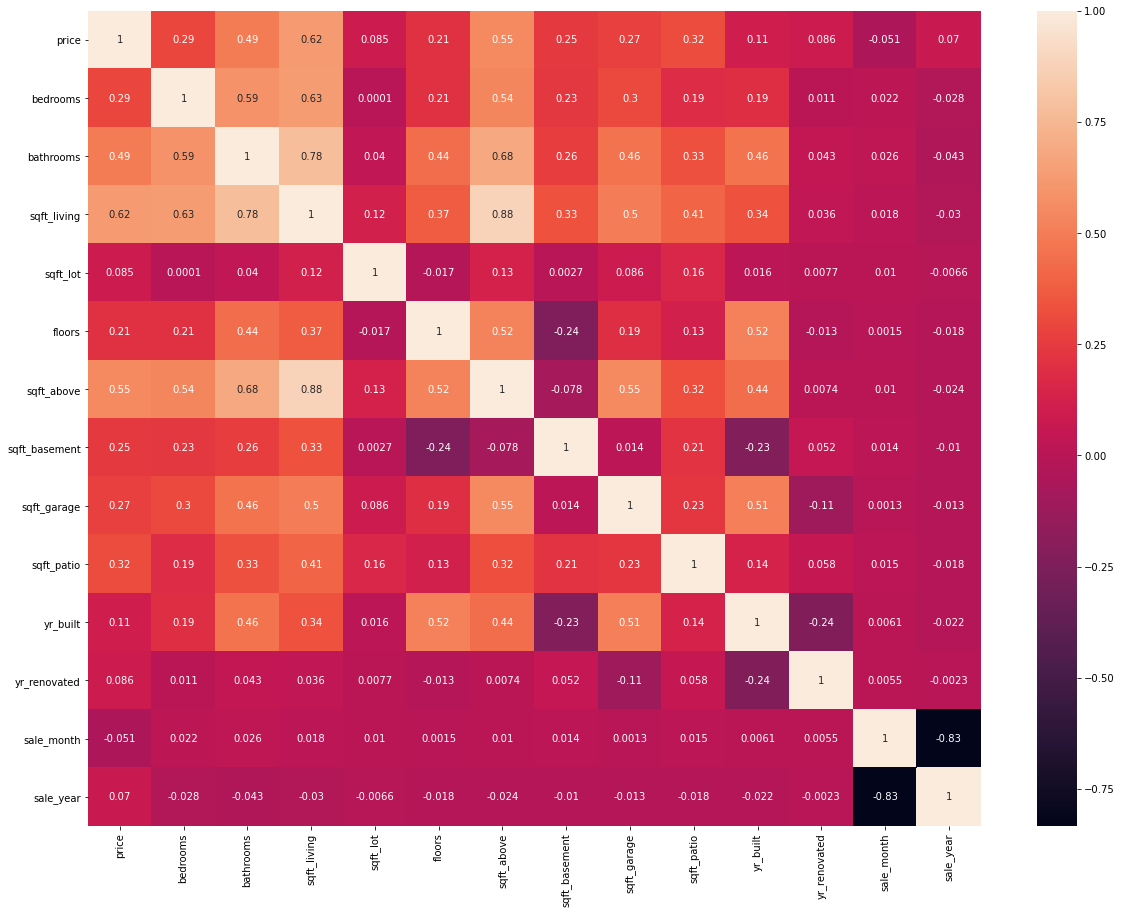

In [234]:
#Run heatmap to identify highly correlated variables to identify possible multi-colinearity 
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot = True)
plt.show();

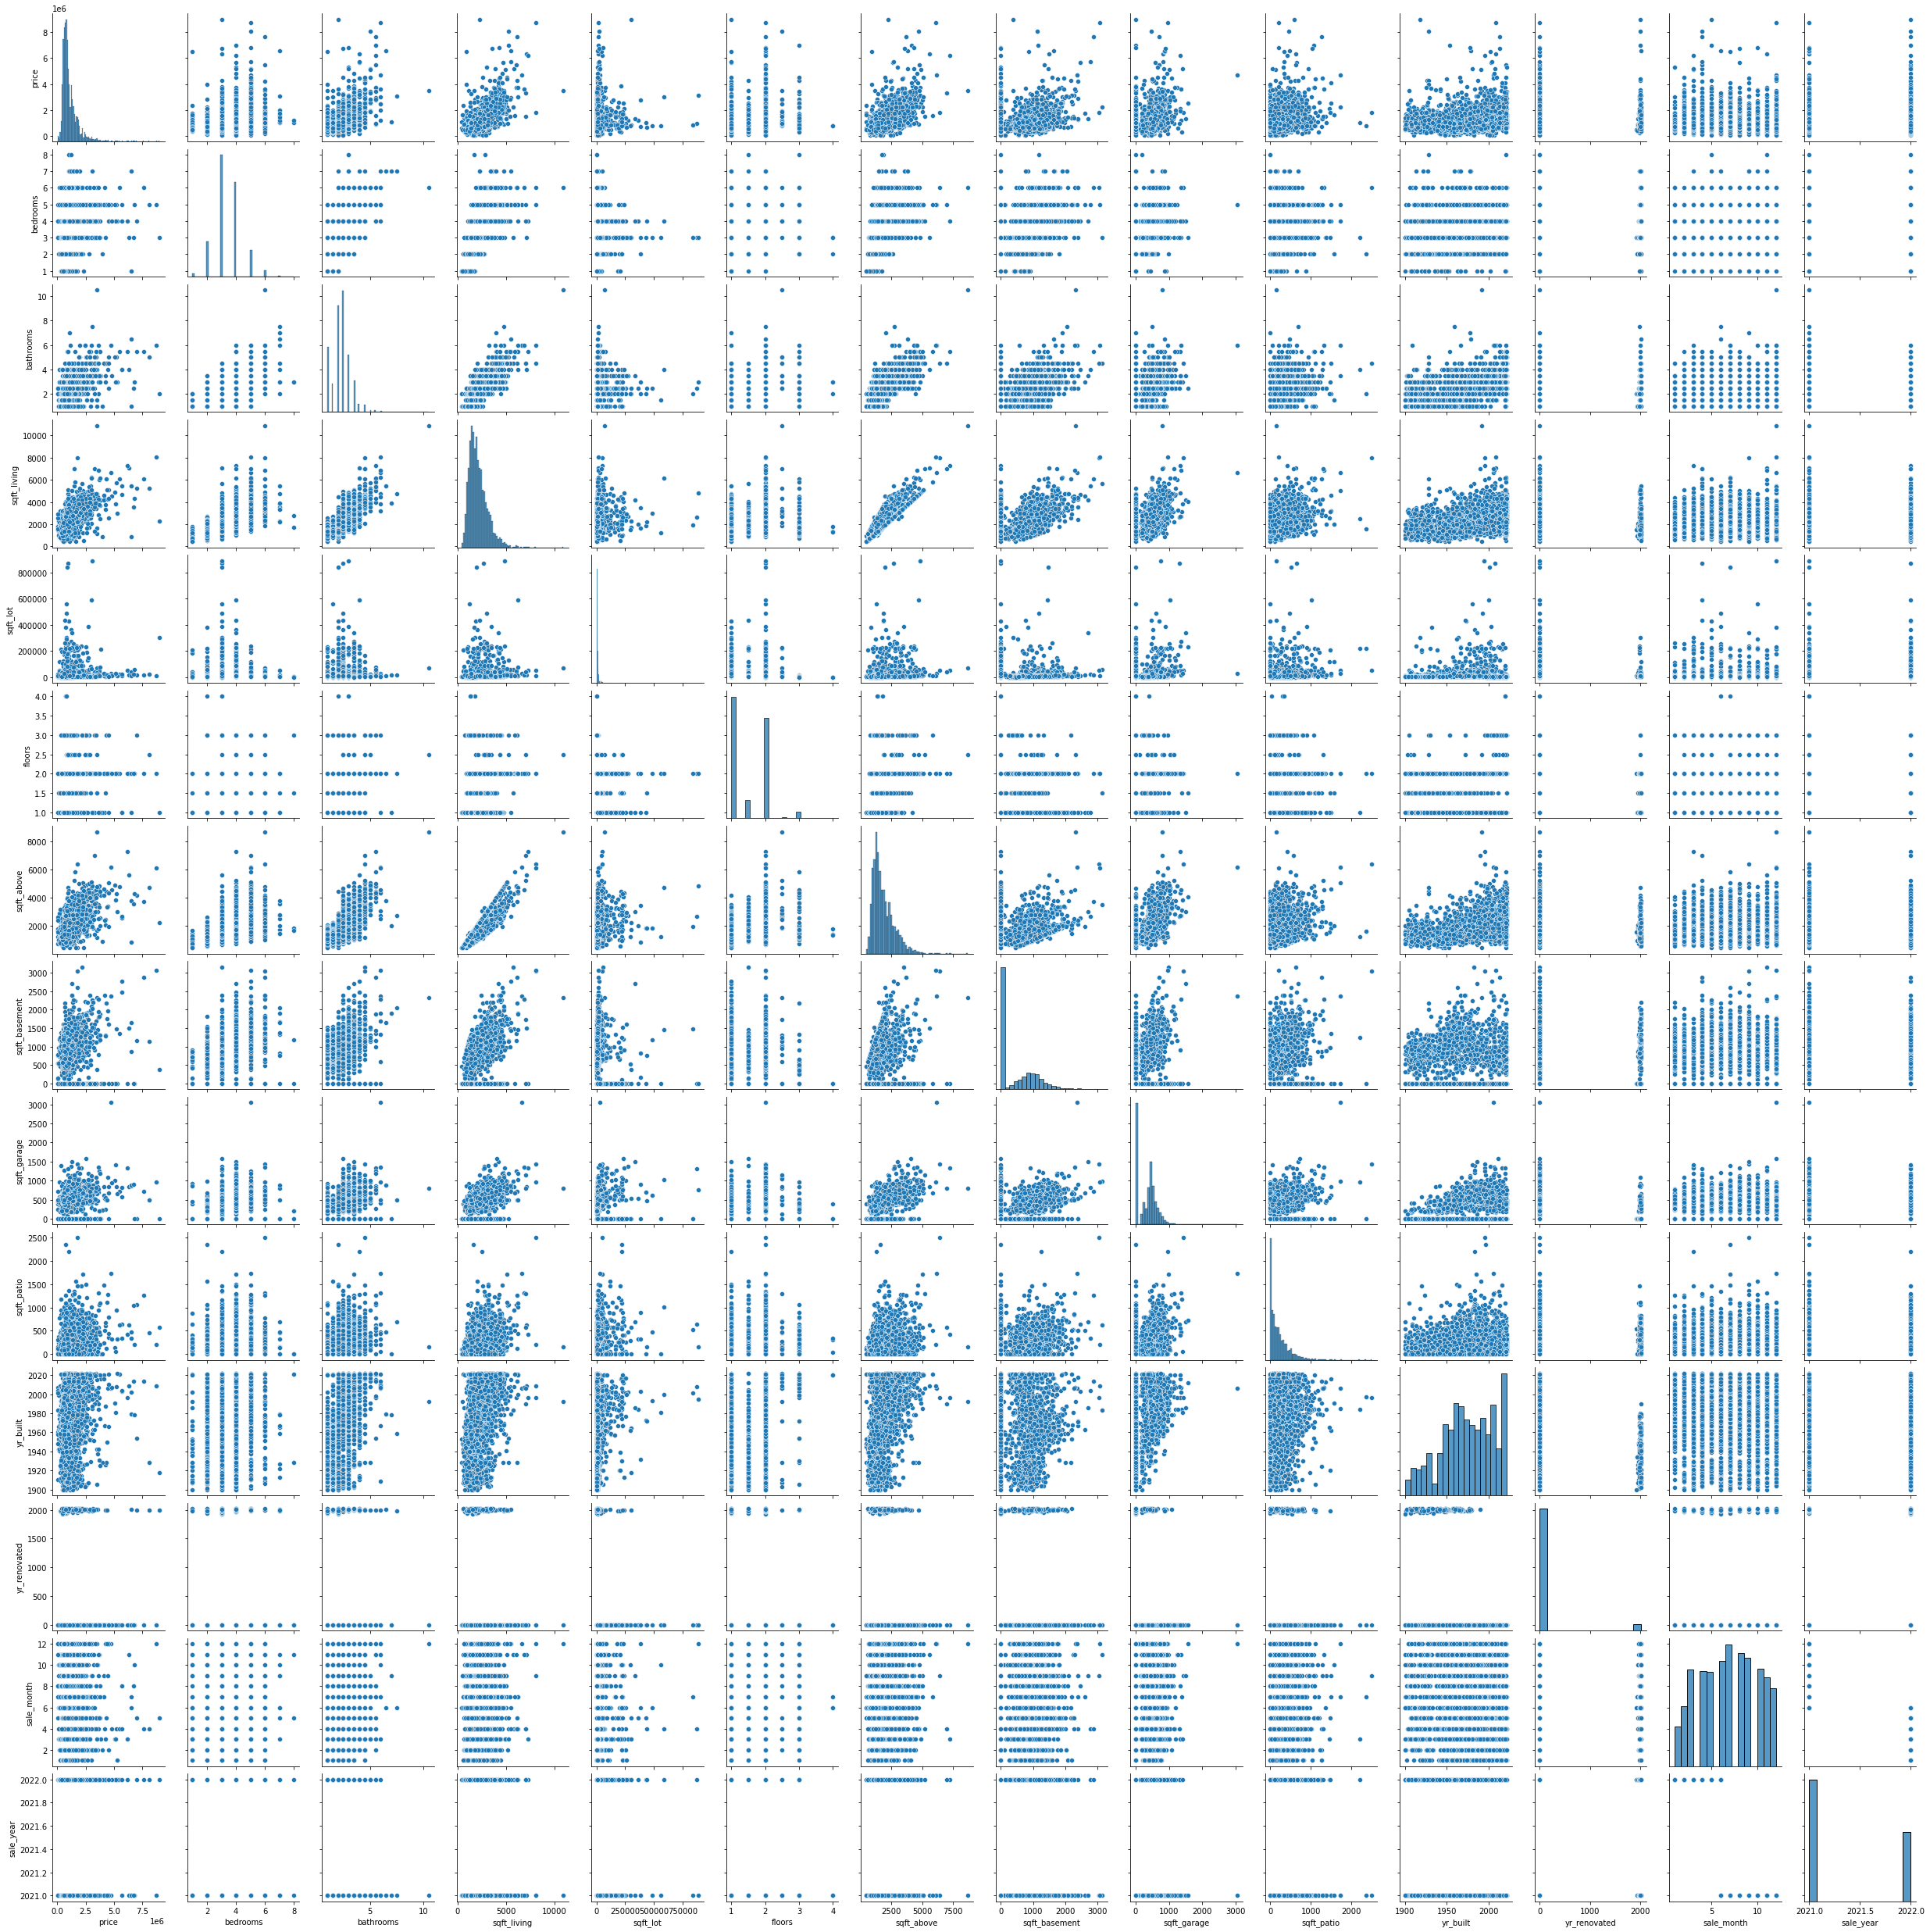

In [235]:
sns.pairplot(df.sample(3000));

1.) sqft_living is the most correlated feature with price 

2.) multi-colinearity between determinents of house size (sqft_living, bedrooms, bathrooms, basement, lot_size)

3.) target (price), sqft_living, sqft_above, sqft_patio not normally distributed. need to log

4.) potential interactions: sqft_lot-sqft-living, sqft_basement-sqft_garage

5.) sqft_living and sqft_above very colinear. probably need to drop one 


In [236]:
#Perform pre-processing transformations on non-normal columns 

df['log_price'] = np.log(df['price'])
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_sqft_above'] = np.log(df['sqft_above'])
df['log_sqft_lot'] = np.log(df['sqft_lot'])

# Baseline Model

In [237]:
# Baseline model will use the single most correlated feature from the original dataframe: sqft_living

model_cols = [ 
 'log_sqft_living']

X = df[model_cols]
y = df['log_price']

base_model = sm.OLS(y, sm.add_constant(X)).fit()
print(base_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 1.587e+04
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:26:50   Log-Likelihood:                -19285.
No. Observations:               28966   AIC:                         3.857e+04
Df Residuals:                   28964   BIC:                         3.859e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.7550      0.048    1

# Model 1: Multi-Linear with Numerics Added

In [238]:
#removing year_renovated to become ordinal later on

#I decided to remove the log features because it decrease R squared from 0.435 to 0.418

model_cols = [ 
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'sale_month',
 'sale_year']

X = df[model_cols]
y = df['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                        columns=X.columns,
                        index=X.index)

#ADDED SCALED TO THE MODEL
model_1 = LinearRegression()
model_1.fit(X_scaled, y)
model_1.score(X_scaled, y)

model_1 = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     1867.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:26:50   Log-Likelihood:                -17313.
No. Observations:               28966   AIC:                         3.465e+04
Df Residuals:                   28953   BIC:                         3.476e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.7392      0.003   5314.621

In [239]:
#Checking for linearity in Model 1

# model_preds = model_1.predict(X_scaled)

# resids = y - model_preds

# fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, figsize=(12, 20))

# ax1.scatter(X['bedrooms'], y)
# ax1.set_title('bedrooms vs y')
# ax2.scatter(X['bathrooms'], y)
# ax2.set_title('bathrooms vs y')
# ax3.scatter(X['sqft_living'], y)
# ax3.set_title('sqft living vs y')
# ax4.scatter(X['sqft_lot'], y)
# ax4.set_title('sqft lot vs y')
# ax5.scatter(X['sqft_above'], y)
# ax5.set_title('sqft above vs y')
# ax6.scatter(X['sqft_garage'], y)
# ax6.set_title('sqft garage vs y')
# ax7.scatter(X['sqft_patio'], y)
# ax7.set_title('sqft pation vs y')
# ax8.scatter(X['yr_built'], y)
# ax8.set_title('yr built vs y');


# Model 2: Multi-Linear Regression with numerical data with interactions and dropped Data

In [240]:
# Creating interactions based on our pairplot above. 

#These interactions increase R squared from 0.435 to 0.439. 
#This only seems to happen when I do not use the log features.

df["sqlivingXsqlot"] = df["log_sqft_living"] * df["sqft_lot"]

df["sqbaseXsqgarage"] = df["sqft_basement"] * df["sqft_garage"]


#This interaction increase R squared from 0.439 to 0.442. But Cond Number is also increased
df['living_interaction'] = df['bedrooms'] * df['bathrooms'] * df['sqft_living'] * df['sqft_above'] * df['floors']



In [241]:
#removed: sqft_garage because it did not lower R squared when removed

model_cols = [ 
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'sqft_patio',
 'yr_built',
 'sale_month',
 'sale_year',
 'sqlivingXsqlot',
 'sqbaseXsqgarage',
 'living_interaction']

X = df[model_cols]
y = df['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                              columns=X.columns,
                              index=X.index)

model_2 = LinearRegression()
model_2.fit(X_scaled, y)
model_2.score(X_scaled, y)

model_2 = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model_2.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     1642.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:26:50   Log-Likelihood:                -17147.
No. Observations:               28966   AIC:                         3.432e+04
Df Residuals:                   28951   BIC:                         3.445e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.7392      0

In [242]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,...,sale_year,City,ZIP,log_price,log_sqft_living,log_sqft_above,log_sqft_lot,sqlivingXsqlot,sqbaseXsqgarage,living_interaction
0,790000.0,3,2.5,1880,3600,2.0,NO,NO,NO,NONE,...,2022,Maple Valley,98038,13.579788,7.539027,7.539027,8.188689,27140.497401,0,53016000.0
1,750000.0,3,2.5,1910,7909,2.0,NO,NO,NO,NONE,...,2022,Tukwila,98168,13.527828,7.554859,7.554859,8.975757,59751.376043,0,54721500.0
2,1250000.0,4,2.5,1750,95396,2.0,NO,NO,NO,NONE,...,2022,Issaquah,98027,14.038654,7.467371,7.467371,11.465792,712357.330300,0,61250000.0
3,757500.0,3,2.5,1910,9170,2.0,NO,NO,NO,NONE,...,2022,Kent,98031,13.537779,7.554859,7.554859,9.123693,69278.052638,0,54721500.0
4,675000.0,3,2.0,2100,7500,1.0,NO,NO,NO,NONE,...,2022,Kirkland,98034,13.422468,7.649693,7.649693,8.922658,57372.694678,0,26460000.0


# Model 3: Adding Binary and Ordinal Categorical Data

In [243]:
# identify which variables are nominal and which are ordinal

df['waterfront'].value_counts()
#waterfront is binary, replace with No = 0, Yes = 1

df['greenbelt'].value_counts()
# #greenbelt is binary, replace with No = 0, Yes = 1

df['nuisance'].value_counts()
# #nuisance is binary, replace with No = 0, Yes = 1

df['view'].value_counts()
# #view is ordinal. Set {None: 0, Fair:1, Average:2, Good:3, Excellent:4}

df['condition'].value_counts()
# #condition is ordinal. Set {Poor: 0, Fair:1, Average:2, Good:3, Very Good:4}

df['grade'].value_counts()
# #grade is ordinal. Set {2 Substandard: 0, 3 Poor: 1, 4 Low: 2, 5 Fair: 3, 6 Low Average: 4, 7 Average: 5,
# # 8 Good: 6, 9 Better: 7, 10 Very Good: 8, 11 Excellent: 9, 12 Luxury: 10, 13 Mansion: 11}

df['yr_renovated'].value_counts()

0       27601
2021       69
2006       49
2018       44
1990       42
        ...  
1924        1
1951        1
1946        1
1972        1
1942        1
Name: yr_renovated, Length: 82, dtype: int64

In [244]:
from sklearn.preprocessing import OrdinalEncoder

#Ordinally Encoding the view, condition, and grade features
ord_cat_selector = ['view', 'condition', 'grade']
cat_subset = df[ord_cat_selector]
view_list = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_list = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
grade_list = ['2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', '9 Better'
              , '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']

o_enc = OrdinalEncoder(categories = [view_list, condition_list, grade_list])
o_enc.fit(cat_subset)
o_enc.transform(cat_subset)

X_ord = pd.DataFrame(o_enc.transform(cat_subset),
                        columns = cat_subset.columns)

#Adding view, condition, and grade to dataframe
X_ord.rename(columns = {'view':'view_ord', 'condition': 'condition_ord', 'grade':'grade_ord'}, inplace = True)
df_ord = pd.concat([df, X_ord], axis =1)
df_ord.head()

#Binary coding for waterfront, greenbelt, nuiance and renovation features
df_ord['waterfront'] = df_ord['waterfront'].map({'NO': 0, 'YES': 1})
df_ord['greenbelt'] = df_ord['greenbelt'].map({'NO': 0, 'YES': 1})
df_ord['nuisance'] = df_ord['nuisance'].map({'NO': 0, 'YES': 1})
df_ord['yr_renovated'] = df_ord["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)



In [245]:
#removed: yr_renovated didn't seem to impact R squared
#removed: living-interaction because it reduced cond no with impact R squared

model_cols = ['bedrooms', 
             'bathrooms', 
             'sqft_living', 
             'sqft_lot', 
             'floors', 
             'sqft_above', 
             'sqft_basement',
             'sqft_patio', 
             'yr_built', 
             'sale_month', 
             'sale_year', 
             'waterfront', 
             'greenbelt', 
             'nuisance', 
             'view_ord', 
             'condition_ord', 
             'grade_ord', 
             'sqlivingXsqlot',
             'sqbaseXsqgarage']

X = df_ord[model_cols]
y = df_ord['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                              columns=X.columns,
                              index=X.index)

model_3 = LinearRegression()
model_3.fit(X_scaled, y)
model_3.score(X_scaled, y)

model_3 = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model_3.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1625.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:26:51   Log-Likelihood:                -15098.
No. Observations:               28966   AIC:                         3.024e+04
Df Residuals:                   28946   BIC:                         3.040e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.7392      0.002   57

# Model 4: Adding Nominal Categorical Data 

In [246]:
#Added: Interaction variables from before and log_sqft_lot
#Removed: Removed City, Bedrooms, and Bathrooms to reduce condo number
#condsider removing: 'sqft_above', 'sqft_basement', 'sqft_garage', and 'sqft_patio' because 
#they do not really impact the R squared in this regression model
#consider removing: heat_source and and sewer_system are not really doing anything

model_cols = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'ZIP',
            'sqlivingXsqlot',
            'sqbaseXsqgarage'
           ]


#Test, Train, Splitting our independnet(y) and dependent(X) variables
X = df_ord[model_cols]
y = df_ord['log_price']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)


# # #added standard scaling: DECREASED AFTER SS
 


#instantiating OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

#transforming train and test OHE columns
train_ohe = ohe.fit_transform(X_train[['ZIP']])
test_ohe = ohe.transform(X_test[['ZIP']])

#turing OHE columns into dataframes
ohe_train = pd.DataFrame(train_ohe, columns = ohe.get_feature_names())
ohe_test = pd.DataFrame(test_ohe, columns = ohe.get_feature_names())

#Concating OHE data with Xtrain and Xtest
X_train = pd.concat([X_train.drop(columns =['ZIP']).reset_index(), ohe_train],1)
X_test = pd.concat([X_test.drop(columns =['ZIP']).reset_index(), ohe_test],1)

#apply standard scalar on numeric and ordinal values 
cols_to_scale = ['sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'sqlivingXsqlot',
            'sqbaseXsqgarage'
           ]

ss = StandardScaler()

X_train[cols_to_scale] =ss.fit_transform(X_train[cols_to_scale])

X_test[cols_to_scale] =ss.fit_transform(X_test[cols_to_scale])

#drop one ZIP column into y_intercept
X_train.drop(columns = ['x0_98050'], inplace = True)
X_test.drop(columns = ['x0_98050'], inplace = True)

# # # #fitting and creating linear model
model_4 = LinearRegression()
model_4.fit(X_train, y_train)
print("This is the train R^2 value: {}".format(round(model_4.score(X_train, y_train), 4)))
print("This is the test R^2 value: {}".format(round(model_4.score(X_test, y_test), 4)))


This is the train R^2 value: 0.7307
This is the test R^2 value: 0.7161


# Model 5: Adding Educational Data

In [247]:
# Create a city/town - school district map

school_district_map = {
    "Seattle" : "Seattle School District",
    "Renton" : "Renton School District",
    "Kent": "Kent School District",
    "Auburn": "Auburn School District",
    "Bellevue": "Bellevue School District",
    "Kirkland": "Lake Washington School District",
    "Federal Way": "Federal Way School District",
    "Redmond": "Lake Washington School District",
    "Sammamish": "Issaquah School District", 
    "Maple Valley": "Tahoma School District",
    "Shoreline": "Shoreline School District",
    "Burien": "Highline School District",
    "Woodinville": "Northshore School District",
    "Issaquah": "Issaquah School District",
    "Covington": "Kent School District",
    "North Bend": "Snoqualmie Valley School District",
    "Enumclaw": "Enumclaw School District",
    "Des Moines": "Highline School District",
    "Mercer Island": "Mercer Island School District",
    "Kenmore": "Northshore School District",
    "Snoqualmie": "Snoqualmie Valley School District",
    "Black Diamond": "Tahoma School District",
    "Bothell": "Northshore School District",
    "SeaTac": "Highline School District",
    "Duvall": "Riverview School District",
    "Lake Forest Park": "Shoreline School District",
    "Vashon": "Vashon Island School District", 
    "Newcastle": "Issaquah School District",
    "Tukwila": "Tukwila School District",
    "Carnation": "Riverview School District",
    "Normandy Park": "Highline School District", 
    "Fall City": "Snoqualmie Valley School District",
    "Pacific": "Auburn School District",
    "Ravensdale": "Tahoma School District",
    "Clyde Hill": "Bellevue School District",
    "Medina": "Bellevue School District",
    "Algona": "Auburn School District",
    "Milton": "Fife School District",
    "Skykomish": "Skykomish School District",
    "Yarrow Point": "Bellevue School District",
    "Beaux Arts": "Bellevue School District",
    "Hunts Point": "Bellevue School District",
    "Baring": "Skykomish School District",
    "Preston": "Issaquah School District",
    "Hobart": "Tahoma School District",
    "Union Hill-Novelty Hill": "Lake Washington School District",
    "Snoqualmie Pass": "Snoqualmie Valley School District",
    "Lakeland North": "Auburn School District",
    "Fairwood": "Kent School District",
    "Cottage Lake": "Northshore School District",
    "Ames Lake": "Snoqualmie Valley School District",
    "White Center": "Highline School District",
    "Dilworth": "Vashon Island School District",
}

school_district_data = {
    "school_district": ["Seattle School District", "Renton School District", "Kent School District", "Auburn School District", "Bellevue School District", "Lake Washington School District", "Federal Way School District", "Issaquah School District", "Tahoma School District", "Shoreline School District", "Highline School District", "Northshore School District", "Snoqualmie Valley School District", "Enumclaw School District", "Mercer Island School District", "Riverview School District", "Vashon Island School District", "Tukwila School District", "Fife School District", "Skykomish School District"],
    
    "math_scores(%)": [51.6, 32.5, 33.7, 30.2, 65.6, 70.2, 21.7, 69.6, 59.0, 55.2, 21.5, 59.6, 64.4, 40.1, 76.9, 54.7, 51.3, 16.7, 30.8, 23.8],
    
    "ela_scores(%)": [62.7, 42.9, 47.9, 43.6, 72.3, 78.5, 35.6, 76.0, 69.2, 66.6, 33.4, 72.0, 75.3, 56.7, 82.0, 69.0, 62.3, 29.6, 46.2, 71.4],
    
    "graduation_rate(%)": [88, 83, 89, 86, 94, 94, 87, 97, 94, 90, 84, 96, 96, 86, 92, 92, 94, 87, 92, 0.0],
    
    "student_expenditure($)": [18397, 16802, 16005, 16463, 17215, 14934, 16332, 15816, 14991, 15900, 17445, 15766, 15168, 15708, 16665, 15508, 16038, 18473, 15264, 58360],
    
    "kindergarten_readiness(%)": [68.3, 56.0, 47.2, 46.4, 60.0, 65.5, 46.0, 74.6, 63.1, 62.5, 55.5, 73.2, 80.6, 61.4, 78.9, 72.8, 75.0, 48.5, 48.3, 0.0],
    
}

df_school = pd.DataFrame(school_district_data)
df_school


,school_district,math_scores(%),ela_scores(%),graduation_rate(%),student_expenditure($),kindergarten_readiness(%)
0,Seattle School District,51.6,62.7,88.0,18397,68.3
1,Renton School District,32.5,42.9,83.0,16802,56.0
2,Kent School District,33.7,47.9,89.0,16005,47.2
3,Auburn School District,30.2,43.6,86.0,16463,46.4
4,Bellevue School District,65.6,72.3,94.0,17215,60.0
5,Lake Washington School District,70.2,78.5,94.0,14934,65.5
6,Federal Way School District,21.7,35.6,87.0,16332,46.0
7,Issaquah School District,69.6,76.0,97.0,15816,74.6
8,Tahoma School District,59.0,69.2,94.0,14991,63.1
9,Shoreline School District,55.2,66.6,90.0,15900,62.5


In [248]:
#merging school data with data frame
df_ord["school_district"] = df_ord["City"].map(school_district_map)
df_ord_edu = pd.merge(df_ord, df_school, on = "school_district")

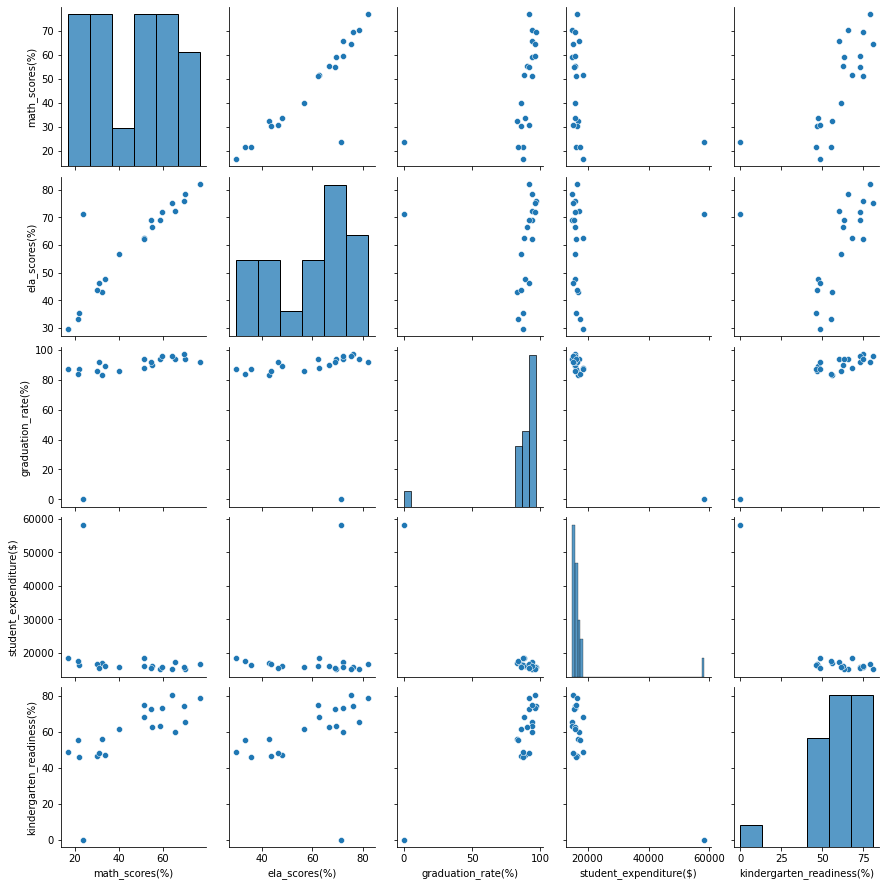

In [249]:
#pairplot of education data (df_school)
sns.pairplot(df_school);

#consider also looing at pairplot of df_ord_edu

Obersvations on pairplot:

1. Math and ELA scores seem to be multicollinear 


2. There seems to be one smaller outlier. this is the Skykomish School District. I think I will remove these values from the data frame.


In [250]:
#removing Skykomish School District
df_ord_edu["school_district"].value_counts()

Seattle School District              9206
Lake Washington School District      2256
Kent School District                 2084
Renton School District               1943
Issaquah School District             1729
Auburn School District               1635
Bellevue School District             1633
Highline School District             1401
Tahoma School District               1231
Northshore School District           1184
Federal Way School District          1165
Shoreline School District            1012
Snoqualmie Valley School District     867
Enumclaw School District              454
Riverview School District             402
Mercer Island School District         348
Vashon Island School District         190
Tukwila School District               178
Fife School District                   26
Skykomish School District              22
Name: school_district, dtype: int64

In [251]:
#removing Skykomish School District
df_ord_edu = df_ord_edu[df_ord_edu["school_district"] != "Skykomish School District"]
df_ord_edu["school_district"].value_counts()

Seattle School District              9206
Lake Washington School District      2256
Kent School District                 2084
Renton School District               1943
Issaquah School District             1729
Auburn School District               1635
Bellevue School District             1633
Highline School District             1401
Tahoma School District               1231
Northshore School District           1184
Federal Way School District          1165
Shoreline School District            1012
Snoqualmie Valley School District     867
Enumclaw School District              454
Riverview School District             402
Mercer Island School District         348
Vashon Island School District         190
Tukwila School District               178
Fife School District                   26
Name: school_district, dtype: int64

In [252]:
#Potential interaction term for the education data
df_ord_edu["score_interaction"] = df_ord_edu["ela_scores(%)"]*df_ord_edu["math_scores(%)"]*df_ord_edu["student_expenditure($)"]

In [253]:
#dropped Math scores

model_cols = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'ZIP',
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction'
           ]


#Test, Train, Splitting our independnet(y) and dependent(X) variables
X = df_ord_edu[model_cols]
y = df_ord_edu['log_price']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

#instantiating OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

#transforming train and test OHE columns
train_ohe = ohe.fit_transform(X_train[['ZIP']])
test_ohe = ohe.transform(X_test[['ZIP']])

#turing OHE columns into dataframes
ohe_train = pd.DataFrame(train_ohe, columns = ohe.get_feature_names())
ohe_test = pd.DataFrame(test_ohe, columns = ohe.get_feature_names())

#Concating OHE data with Xtrain and Xtest
X_train = pd.concat([X_train.drop(columns =['ZIP']).reset_index(), ohe_train],1)
X_test = pd.concat([X_test.drop(columns =['ZIP']).reset_index(), ohe_test],1)

#apply standard scalar on numeric and ordinal values 
cols_to_scale = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction'
           ]


ss = StandardScaler()

X_train[cols_to_scale] =ss.fit_transform(X_train[cols_to_scale])

X_test[cols_to_scale] =ss.fit_transform(X_test[cols_to_scale])

#drop one ZIP column into y_intercept
X_train.drop(columns = ['x0_98050'], inplace = True)
X_test.drop(columns = ['x0_98050'], inplace = True)


#fitting and creating linear model
model_5 = LinearRegression()
model_5.fit(X_train, y_train)
print("This is the train R^2 value: {}".format(round(model_5.score(X_train, y_train), 4)))
print("This is the test R^2 value: {}".format(round(model_5.score(X_test, y_test), 4)))

dict(zip(X_test.columns, model_5.coef_))

This is the train R^2 value: 0.7269
This is the test R^2 value: 0.7261


{'index': 8.334188096304723e-06,
 'sqft_living': 0.12249569204948327,
 'log_sqft_lot': 0.061427589145618015,
 'floors': 0.001063159925829421,
 'sqft_above': 0.10363676166103143,
 'sqft_basement': 0.025067963959847256,
 'sqft_garage': 0.018494279321980167,
 'sqft_patio': 0.002863988947999996,
 'yr_built': 0.02589271927895248,
 'yr_renovated': 0.020750365909828462,
 'sale_month': 0.04356352704996844,
 'sale_year': 0.11100074166725232,
 'living_interaction': -0.027227913114430666,
 'waterfront': 0.03276286071104134,
 'greenbelt': 0.00848090573476317,
 'nuisance': -0.01867525169545559,
 'view_ord': 0.04779217692571866,
 'condition_ord': 0.05133895213567924,
 'grade_ord': 0.08624723825425573,
 'sqlivingXsqlot': 0.007957077275573626,
 'sqbaseXsqgarage': -0.017664598150968547,
 'ela_scores(%)': -0.17017517110408303,
 'graduation_rate(%)': 0.15540040372835698,
 'student_expenditure($)': 0.07222071115118424,
 'kindergarten_readiness(%)': -0.005892599740377258,
 'score_interaction': 0.1584031118

# Model 6: Add Crime Data 

In [254]:
crime_df = pd.read_csv("data-pozo/crime.csv")
crime_df1 = crime_df.drop(columns = ["case_number", "nibrs_code", "reporting_area", "district", "precinct", "created_at", "updated_at", "hour_of_day", "day_of_week", "ID"])
crime_df1["Year"] = crime_df1["incident_datetime"].apply(lambda x: x[6:10])
crime_df1["city"] = crime_df1["city"].apply(lambda x: str(x).lower().title())
crime_df1.rename(columns = {"city": "City"}, inplace = True)
crime_df1.drop_duplicates(inplace = True)
crime_df1 = crime_df1[(crime_df1["Year"] == "2021") | (crime_df1["Year"] == "2022")]
crime_df1 = crime_df1.drop(columns = ["incident_datetime"])

city_list = ["Seattle", "Renton", "Kent", "Auburn", "Bellevue", "Kirkland", "Federal Way", "Redmond", "Sammamish", "Maple Valley", "Shoreline", "Burien", "Woodinville", "Issaquah", "Covington", "North Bend", "Enumclaw", "Des Moines", "Mercer Island", "Kenmore", "Snoqualmie", "Black Diamond", "Bothell", "Seatac", "Duvall", "Lake Forest Park", "Vashon", "Newcastle", "Tukwila", "Carnation", "Normandy Park", "Fall City", "Pacific", "Ravensdale", "Clyde Hill", "Medina", "Algona", "Milton", "Skykomish", "Yarrow Point", "Beaux Arts", "Hunts Point", "Baring", "Preston", "Hobart", "Union Hill-Novelty Hill", "Snoqualmie Pass", "Lakeland North", "Fairwood", "Cottage Lake", "Ames Lake", "White Center", "Dilworth"]
crime_df1 = crime_df1[crime_df1['City'].isin(city_list)]
crime_df1.dropna(subset = ["nibrs_code_name"])
crime_by_city = crime_df1.groupby(["City"]).count()
crime_by_city = crime_by_city[["nibrs_code_name"]].reset_index()
crime_by_city.rename(columns = {"nibrs_code_name": "crime_number"}, inplace = True)


pop_dict = {"Seattle": 762500, "Renton": 107500, "Kent": 137900, "Auburn": 78690, "Bellevue": 153900, "Kirkland": 93570, "Federal Way": 101800, "Redmond": 75270, "Sammamish": 68150, "Maple Valley": 28920, "Shoreline": 60320, "Burien": 52490, "Woodinville": 13450, "Issaquah": 40950, "Covington": 21200, "North Bend": 7915, "Enumclaw": 12910, "Des Moines": 33160, "Mercer Island": 25780, "Kenmore": 137900, "Snoqualmie": 14490, "Black Diamond": 6145, "Bothell": 29210, "Seatac": 31910, "Duvall": 8320, "Lake Forest Park": 13620, "Vashon": 11055, "Newcastle": 13560, "Tukwila": 22620, "Carnation": 2160, "Normandy Park": 6790, "Fall City": 2032, "Pacific": 7230, "Ravensdale": 390, "Clyde Hill": 3110, "Medina": 2915, "Algona": 3300, "Milton": 13560, "Skykomish": 165, "Yarrow Point": 1125, "Beaux Arts": 315, "Hunts Point": 460, "Baring": 267, "Preston": 523, "Hobart": 6932, "Union Hill-Novelty Hill": 22683, "Snoqualmie Pass": 390, "Lakeland North": 13879, "Fairwood": 10541, "Cottage Lake": 22965, "Ames Lake": 1486, "White Center": 16631, "Dilworth": 0.0}
pop_df = pd.DataFrame(pop_dict, index = [0])
pop_df = pop_df.transpose()
pop_df = pop_df.sort_index()
pop_df = pop_df.reset_index()
pop_df.rename(columns = {"index": "City", 0: "Population"}, inplace = True)

crime_per_capita = pd.merge(crime_by_city, pop_df, on = "City")
crime_per_capita["crime_per_capita"] = crime_per_capita["crime_number"]/ crime_per_capita["Population"]

df_ord_edu_crime = pd.merge(df_ord_edu, crime_per_capita, on = "City")
df_ord_edu_crime.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,...,school_district,math_scores(%),ela_scores(%),graduation_rate(%),student_expenditure($),kindergarten_readiness(%),score_interaction,crime_number,Population,crime_per_capita
0,790000.0,3,2.5,1880,3600,2.0,0,0,0,NONE,...,Tahoma School District,59.0,69.2,94.0,14991,63.1,61205254.8,1255,28920.0,0.043396
1,1150000.0,5,3.5,3530,8000,2.0,0,0,0,NONE,...,Tahoma School District,59.0,69.2,94.0,14991,63.1,61205254.8,1255,28920.0,0.043396
2,540000.0,4,2.0,1060,7295,1.0,0,0,0,NONE,...,Tahoma School District,59.0,69.2,94.0,14991,63.1,61205254.8,1255,28920.0,0.043396
3,625000.0,2,1.0,1430,16317,1.0,0,0,0,NONE,...,Tahoma School District,59.0,69.2,94.0,14991,63.1,61205254.8,1255,28920.0,0.043396
4,427500.0,3,2.0,1090,17894,1.0,0,0,0,NONE,...,Tahoma School District,59.0,69.2,94.0,14991,63.1,61205254.8,1255,28920.0,0.043396


In [255]:
model_cols = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'ZIP',
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction',
            'crime_per_capita'
           ]


#Test, Train, Splitting our independnet(y) and dependent(X) variables
X = df_ord_edu_crime[model_cols]
y = df_ord_edu_crime['log_price']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

#instantiating OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

#transforming train and test OHE columns
train_ohe = ohe.fit_transform(X_train[['ZIP']])
test_ohe = ohe.transform(X_test[['ZIP']])

#turing OHE columns into dataframes
ohe_train = pd.DataFrame(train_ohe, columns = ohe.get_feature_names())
ohe_test = pd.DataFrame(test_ohe, columns = ohe.get_feature_names())

#Concating OHE data with Xtrain and Xtest
X_train = pd.concat([X_train.drop(columns =['ZIP']).reset_index(), ohe_train],1)
X_test = pd.concat([X_test.drop(columns =['ZIP']).reset_index(), ohe_test],1)

#apply standard scalar on numeric and ordinal values 
cols_to_scale = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction',
            'crime_per_capita'
           ]


ss = StandardScaler()

X_train[cols_to_scale] =ss.fit_transform(X_train[cols_to_scale])

X_test[cols_to_scale] =ss.fit_transform(X_test[cols_to_scale])

#drop one ZIP column into y_intercept
X_train.drop(columns = ['x0_98050'], inplace = True)
X_test.drop(columns = ['x0_98050'], inplace = True)

#fitting and creating linear model
model_6 = LinearRegression()
model_6.fit(X_train, y_train)
print("This is the train R^2 value: {}".format(round(model_6.score(X_train, y_train), 4)))
print("This is the test R^2 value: {}".format(round(model_6.score(X_test, y_test), 4)))

This is the train R^2 value: 0.7093
This is the test R^2 value: 0.7335
